##### <h1 id="aa" align="center"> A STUDY OF BANK CUSTOMER CHURN </h1> 


Description of each variable:
<ul>
<li>Credit_score — credit rating </li>
<li>geography — client country</li>
<li>gender — client gender</li>
<li>age — client age</li>
<li>tenure — number of years spent by the client with the bank </li>
<li>balance — client account balance</li>
<li>num_of_product — number of products that the client purchased from the bank</li>
<li>has_cr_card — the client has a credit card</li>
<li>is-_active_member — active client </li>
<li>estimated_salary — clien salary</li>
<li>exited — client left the bank </li>    
</ul>

In [19]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt   #plt.xkcd()
from IPython.display import set_matplotlib_formats
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
from utilities import *
import scipy.stats as ss
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Improve quality of the plots
set_matplotlib_formats('svg')
# Set the style of the plot
plt.style.use('seaborn-v0_8-white')
#plt.xkcd()

## 1-Load and clean the data

In [21]:
# Load the data
df = pd.read_csv("churn.csv", index_col=False)
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


* At least 3 columns do not provide training value : RowNumber, CustomerId and Surname


In [22]:
col_name = ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 
            'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

In [23]:
# Remove unnecessary variables
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
# Change the columns name
df.columns = col_name
# Show the data
df.head(5)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


* The set contains information about 10,000 bank users

* No empty values found

* There are both nominative and quantitative characteristics

In [25]:
# Number of unique value for each variable
df.nunique()

credit_score         460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
num_of_products        4
has_cr_card            2
is_active_member       2
estimated_salary    9999
exited                 2
dtype: int64

## 2-Statistics and data visualisation

### Bar plot of binary variables

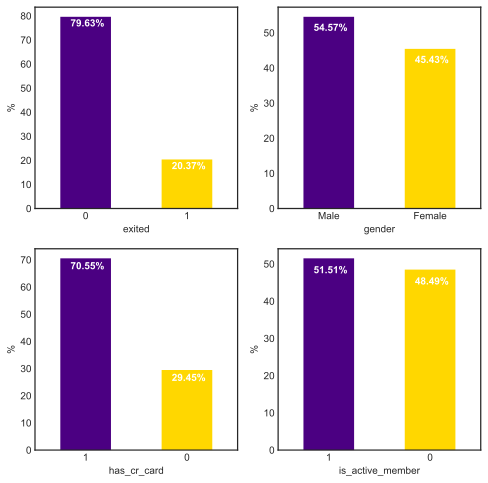

In [26]:
plt.figure(figsize=(8, 8))
bar_columns = ["exited", "gender", "has_cr_card", "is_active_member"]
counter = 1
for key in bar_columns:
    plt.subplot(2, 2, counter)
    bar_plot(df[key], x_label=key, y_label="%", color=['indigo', 'gold'])
    counter += 1

* Gender and activities among customers are evenly distributed.
* The proportion of customers holding a credit card is lower.
* The proportion of exiting customers is low.

### Box plot of continuous variables

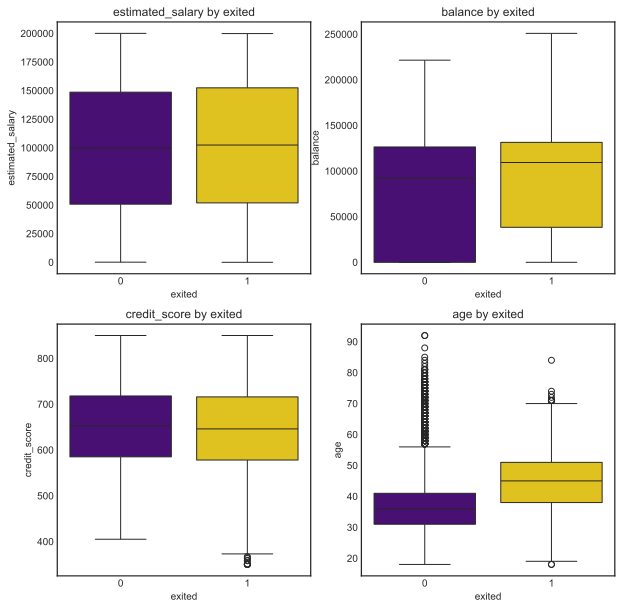

In [27]:
numeric_col = ['estimated_salary', 'balance', 'credit_score','age']

plt.figure(figsize=(10, 10))
counter = 1
for key in numeric_col:
    plt.subplot(2, 2, counter)
    sns.boxplot(x = df['exited'], y = df[key], palette=['indigo', 'gold'])\
                                                    .set(title=f'{key} by exited')
    counter += 1

### Correlation between numerical variables

Text(0.5, 1.0, 'Correlation Plot')

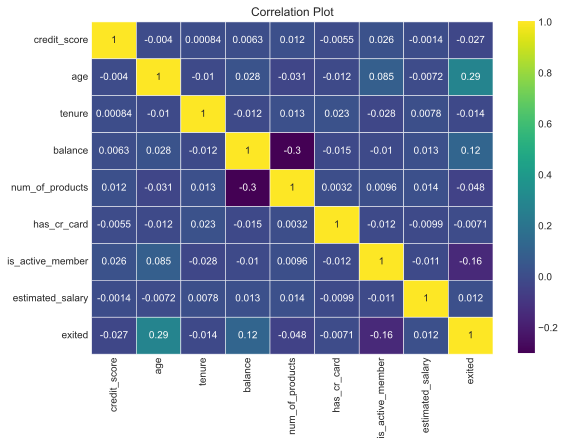

In [28]:
# Correlation between numrical variable
plt.figure(figsize=(9, 6))
sns.heatmap(df.drop(['geography', 'gender'], axis=1).corr(), annot=True, cmap='viridis', linewidths=.5)
plt.title('Correlation Plot')

* Based on the chart provided, there is no strong linear relationship observed between the variables.

### Association between categorical variables

For this purpose, we will use Cramer's V. It measures how strongly two categorical fields are associated.

$$
\mathcal{V} = \sqrt{\frac{\chi^2/n}{min(r-1, c-1)}}
$$

In [29]:
categorical_col = ["num_of_products", "gender", "has_cr_card", "is_active_member", "geography"]
score = {}
exited = df["exited"]
for col in categorical_col:
    temp = df[col]
    the_confusion_matrix = pd.crosstab(exited, temp).to_numpy()
    score[col] = CramerV(the_confusion_matrix, True)

score = pd.Series(score, index=categorical_col).sort_values(ascending=False)

Text(0.5, 1.0, 'Exited and Categorical')

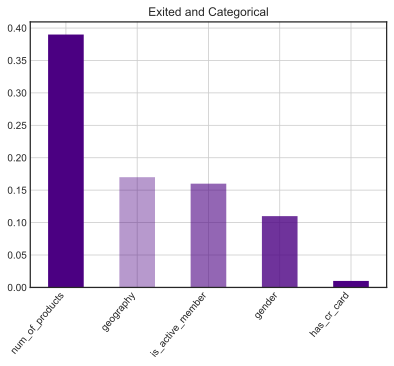

In [30]:
score.plot(kind="bar", grid=True, color=['#4B0082', '#4B008266', '#4B008299', '#4B0082CC'])
plt.xticks(rotation=50, ha='right')
plt.title('Exited and Categorical')

* A Cramer's V value of 0.4 indicates a moderate level of association between `exited` and `num_of_products`. The association is more substantial compared to the previous value, but it's still not very strong.

* The remaine variables suggests a relatively weak association with the `exited` variable.

### Distribution of continuous variables

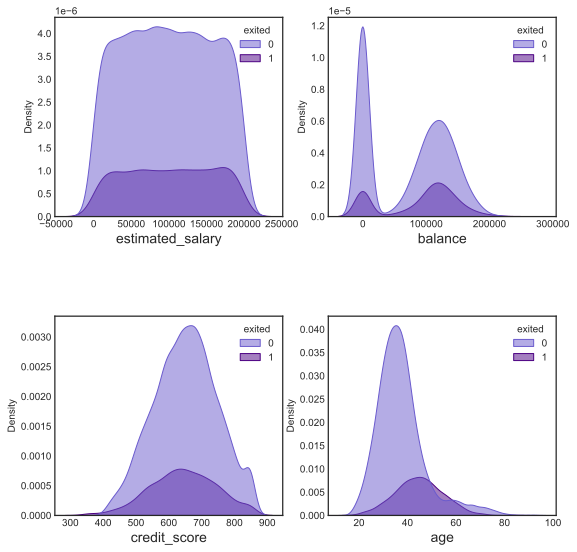

In [31]:
fig, axes = plt.subplots(2,2, figsize = (9,9))
plt.subplots_adjust(hspace=0.5)
columns = df[numeric_col]
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df,
                x = column,
                fill = True,
                alpha = 0.5,
                hue = 'exited',
                palette = ['#6A5ACD', '#4B0082'],
                ax = ax)
    ax.set_xlabel(column, fontsize = 14)
plt.show()

* Given the distributions above, we observe that the distribution changes when clients exit or stay.
* We observe a heavy tail in the distributions, which implies higher probabilities for the extreme values.
* Clients over 70 and below 20 have a higher chance of not exiting..

In [54]:
numeric_col


['estimated_salary', 'balance', 'credit_score', 'age']

<Axes: xlabel='balance', ylabel='estimated_salary'>

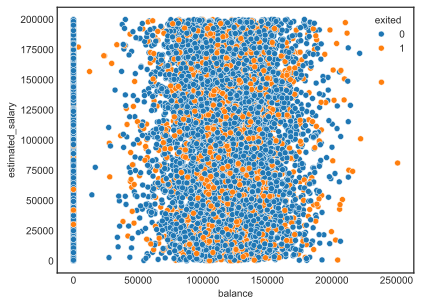

In [56]:
sns.scatterplot(x="balance", y="estimated_salary", hue="exited", color=["indigo", "gold"], data=df)

In [55]:

#sns.scatterplot(x="balance", y="estimated_salary", hue="exited", color=["indigo", "gold"], data=df)

# fig, axes = plt.subplots(2,2, figsize = (9,9))
# plt.subplots_adjust(hspace=0.5)
# columns = df[numeric_col]
# for i, column in enumerate(columns):
#     ax = axes[i // 2, i % 2]
#     sns.scatterplot(data = df,
#                 x = column,
#                 fill = True,
#                 alpha = 0.5,
#                 hue = 'exited',
#                 palette = ['#6A5ACD', '#4B0082'],
#                 ax = ax)
#     ax.set_xlabel(column, fontsize = 14)
# plt.show()

### Summary of continuous variables

In [32]:
# Summary of numerical variables
df[numeric_col].describe()

,estimated_salary,balance,credit_score,age
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100090.239881,76485.889288,650.528800,38.921800
std,57510.492818,62397.405202,96.653299,10.487806
min,11.580000,0.000000,350.000000,18.000000
25%,51002.110000,0.000000,584.000000,32.000000
50%,100193.915000,97198.540000,652.000000,37.000000
75%,149388.247500,127644.240000,718.000000,44.000000
max,199992.480000,250898.090000,850.000000,92.000000


### Mean of continuous variables given the exited variable

In [33]:
ex_cr = df.groupby('exited')['credit_score'].mean().reset_index()
ex_age = df.groupby('exited')['age'].mean().reset_index()
merge_1 = pd.merge(ex_cr, ex_age, on='exited')
ex_salary = df.groupby('exited')['estimated_salary'].mean().reset_index()
merge_2 = pd.merge(merge_1, ex_salary, on='exited')
ex_balance = df.groupby('exited')['estimated_salary'].mean().reset_index()
pd.merge(merge_2, ex_balance, on='exited')

,exited,credit_score,age,estimated_salary_x,estimated_salary_y
0,0,651.853196,37.408389,99738.391772,99738.391772
1,1,645.351497,44.837997,101465.677531,101465.677531


Visually, the conditional mean of continuous variables shows minimal distinctions.

To validate this observation, we will conduct statistical tests.

We will test if 

$$
H_0 : \mathbb{E}[X_i|exited = 1] - \mathbb{E}[X_i|exited = 0] = 0
$$

$$
H_1 : \mathbb{E}[X_i|exited = 1] - \mathbb{E}[X_i|exited = 0] \neq 0
$$

$H_0$ : No significant difference between the means

$H_1$ : There is a significant difference between the means

The sample mean : $\bar{Y}_{1} = \frac{1}{n_1}\sum_{i=1}^{n_1}Y_{1, i}$   and   $\bar{Y}_{2} = \frac{1}{n_2}\sum_{i=1}^{n_2}$


The sample variance : $S^2_1 = \frac{1}{n_1-1}\sum_{i=1}^{n_1}(Y_{1,i} - \bar{Y}_{1})^2$ and $S^2_2 = \frac{1}{n_2-1}\sum_{i=1}^{n_2}(Y_{2,i} - \bar{Y}_{2})^2$

$S^2_p = \frac{(n_1 - 1)S^2_1 + (n_2 - 1)S^2_2}{n_1 + n_2 - 2}$

$S^2_p$ : is the common variance estimation

We calculate the t value :

$$
t = \frac{\bar{Y}_{1} - \bar{Y}_{2}}{S_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}
$$

Finaly, after setting a level $\alpha$, we can calcula the `p_value`. If the $p-value > \alpha$ we don't reject $H_0$, otherwise, we rejected.

$$
p-value = \mathbb{P}(T > |t|)
$$

where 

$$
T \sim \mathcal{Student}(n_1 + n_2 -2)
$$

In [34]:
student_test(df, numeric_col, group_by='exited', alpha_level=0.05)

[estimated_salary, exited] : Fail to reject the null hypothesis with level 0.05; there is no significant difference between groups.
===
[balance, exited] : Reject the null hypothesis with level 0.05; there is a significant difference between groups.
===
[credit_score, exited] : Reject the null hypothesis with level 0.05; there is a significant difference between groups.
===
[age, exited] : Reject the null hypothesis with level 0.05; there is a significant difference between groups.
===


* There is no significant difference in the mean of `estimated_salary` between individuals who stay and those who exit.
* For the other variables, according to the t-test results, there is a significant difference.

## 3-Implementation of predictive models.

Creating binary columns for each category and indicates the presence of the category with a 1 in the corresponding column. This is suitable when there is no ordinal relationship among the categories.

In [35]:
df= pd.get_dummies(df, columns=['geography'], prefix="is")
df["gender"] = df["gender"].replace({"Female":1, "Male":0})
exited = df.pop("exited")
df["exited"] = exited
df.head(10)

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,is_France,is_Germany,is_Spain,exited
0,619,1,42,2,0.00,1,1,1,101348.88,True,False,False,1
1,608,1,41,1,83807.86,1,0,1,112542.58,False,False,True,0
2,502,1,42,8,159660.80,3,1,0,113931.57,True,False,False,1
3,699,1,39,1,0.00,2,0,0,93826.63,True,False,False,0
4,850,1,43,2,125510.82,1,1,1,79084.10,False,False,True,0
5,645,0,44,8,113755.78,2,1,0,149756.71,False,False,True,1
6,822,0,50,7,0.00,2,1,1,10062.80,True,False,False,0
7,376,1,29,4,115046.74,4,1,0,119346.88,False,True,False,1
8,501,0,44,4,142051.07,2,0,1,74940.50,True,False,False,0
9,684,0,27,2,134603.88,1,1,1,71725.73,True,False,False,0
